# Regression Analysis of Small Data Using K-Fold
A model for predicting house prices in Boston

## Preparation

### Load the Library

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

tf.__version__

'2.7.4'

### Prepare Training Data

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.boston_housing.load_data()
type(train_x), train_x.shape, test_x.shape, type(train_y), train_y[0]

65536/57026 [==================================] - 0s 0us/step


(numpy.ndarray, (404, 13), (102, 13), numpy.ndarray, 15.2)

#### Preprocessing
Normalize each column value to a value between -1 and 1

In [15]:
train_mean = train_x.mean(axis=0)
train_x -= train_mean
train_std = train_x.std(axis=0)
train_x /= train_std

test_x -= train_mean
test_x /= train_std

## Model

### Define

In [19]:
def build_nlp_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=train_x.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)  # `activation` is not used in regression
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Training using K-Fold

In [23]:
K = 4
VALID_SIZE = len(train_x) // K
EPOCHS = 100
BATCH_SIZE = 1

all_mae_histories = []

start_train = datetime.now()
print(f"Start Training: {start_train}")
for i in range(K):
    start_fold = datetime.now()
    print(f"{i+1} fold: (Start) {start_fold}, ", end="")
    
    _valid_x = train_x[i*VALID_SIZE:(i+1)*VALID_SIZE]
    _valid_y = train_y[i*VALID_SIZE:(i+1)*VALID_SIZE]
    _train_x = np.concatenate([train_x[:i*VALID_SIZE], train_x[(i+1)*VALID_SIZE:]], axis=0)
    _train_y = np.concatenate([train_y[:i*VALID_SIZE], train_y[(i+1)*VALID_SIZE:]], axis=0)

    model = build_nlp_model()
    history = model.fit(_train_x, _train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        validation_data=(_valid_x, _valid_y), verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    end_fold = datetime.now()
    print(f"(End) {end_fold}, (Processing Time) {end_fold-start_fold}")
    
mean_mae_histories = [np.mean([x[i] for x in all_mae_histories]) for i in range(EPOCHS)]
end_train = datetime.now()
print(f"End Training: {end_train}, Processing Time: {end_train-start_train}")

Start Training: 2022-10-10 23:14:57.558192
1 fold: (Start) 2022-10-10 23:14:57.558377, (End) 2022-10-10 23:15:37.617899, (Processing Time) 0:00:40.059522
2 fold: (Start) 2022-10-10 23:15:37.617962, (End) 2022-10-10 23:16:18.020400, (Processing Time) 0:00:40.402438
3 fold: (Start) 2022-10-10 23:16:18.020467, (End) 2022-10-10 23:16:58.028078, (Processing Time) 0:00:40.007611
4 fold: (Start) 2022-10-10 23:16:58.028140, (End) 2022-10-10 23:17:38.001457, (Processing Time) 0:00:39.973317
End Training: 2022-10-10 23:17:38.003134, Processing Time: 0:02:40.444942


#### Find Optimal(=Minimum) Epochs
Overfitting occurs after minimum epochs

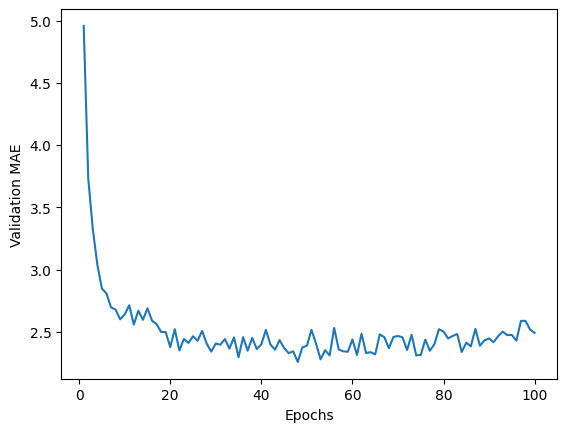

In [25]:
plt.plot(range(1, len(mean_mae_histories)+1), mean_mae_histories)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [26]:
minimum_epochs = np.argmin(mean_mae_histories)
minimum_epochs

47

#### Training Model(Minimum Epochs)

In [29]:
model_final = build_nlp_model()
model_final.fit(train_x, train_y, epochs=minimum_epochs, batch_size=8, verbose=0)
_, mae = model_final.evaluate(test_x, test_y, verbose=0)
mae

2.70597767829895